# Import section

In [1]:
%load_ext autoreload
%autoreload 2

from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import scikitplot as skplot
from sklearn import linear_model
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPRegressor


from context import ml_project
from ml_project.io import DataHandler
from ml_project.estimators import MeanValueClassifier

# Download data - HowTo

1) Download the zip folder from the web  
2) Create a directory inside the PROJECT_ROOT_DIR/data/ and give it a suitable name (DIR_NAME)  
3) Extract the files from the zip folder into DIR_NAME  
4) Set the correct DIR_NAME in the following cell

In [2]:
DIR_NAME = 'task0_data'

# Load all data (train and test data)

In [3]:
data_handler = DataHandler(DIR_NAME)
data = data_handler.load_train_and_test_data()

train_X = data['train_data'].drop(['y'], axis=1)
train_Y = data['train_data']['y']

test_X = data['test_data']


# Fitting the model on training data and performing predictions on test data

In [26]:
# This would be the actual procedure, given we would NOT know that the predicted value is the mean of all features

pipe_clf = Pipeline(
                    [('std_scale', StandardScaler()),
                     ('pca', PCA()),
                     ('regr', linear_model.LinearRegression(normalize=True))
                     
])

param_grid = {
    'pca__n_components': [10],
}

grid_clf = GridSearchCV(pipe_clf, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')

grid_clf.fit(train_X, train_Y)

predictions = pd.DataFrame(grid_clf.predict(test_X))

predictions = predictions.rename(columns = {0:'y'})
predictions.index = test_X.index

In [37]:
print('\nGridsearch CV results:\n')
pprint(grid_clf.cv_results_)
best_estimator = grid_clf.best_estimator_
print('\nBest estimator:\n')
pprint(best_estimator)


Gridsearch CV results:

{'mean_fit_time': array([0.00998155]),
 'mean_score_time': array([0.00254679]),
 'mean_test_score': array([-1.75641457e-25]),
 'mean_train_score': array([-1.70979745e-25]),
 'param_pca__n_components': masked_array(data=[10],
             mask=[False],
       fill_value='?',
            dtype=object),
 'params': [{'pca__n_components': 10}],
 'rank_test_score': array([1], dtype=int32),
 'split0_test_score': array([-1.35508762e-25]),
 'split0_train_score': array([-1.34434708e-25]),
 'split1_test_score': array([-2.87186123e-25]),
 'split1_train_score': array([-2.75412599e-25]),
 'split2_test_score': array([-1.04241529e-25]),
 'split2_train_score': array([-1.03091929e-25]),
 'std_fit_time': array([0.00242916]),
 'std_score_time': array([0.00077352]),
 'std_test_score': array([7.98944377e-26]),
 'std_train_score': array([7.4945572e-26])}

Best estimator:

Pipeline(memory=None,
     steps=[('std_scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca'

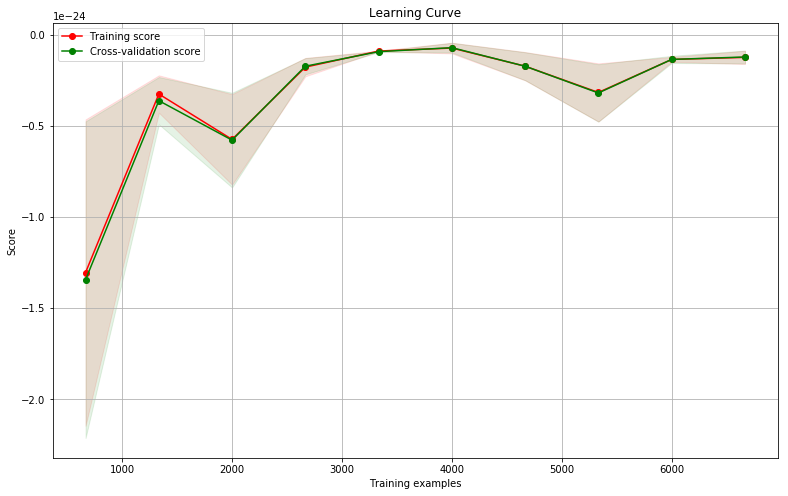

In [34]:
skplot.estimators.plot_learning_curve(pipe_clf, train_X, train_Y, train_sizes=np.linspace(.1, 1.0, 10), 
                                      figsize=(13, 8), cv=3, scoring='neg_mean_squared_error')

In [38]:
# But... In this dummy task we know that the predicted value has to be the mean of the features, so

dummy_clf = MeanValueClassifier()

predictions = pd.DataFrame(dummy_clf.predict(test_X))  # Predict on untransformed data.

predictions = predictions.rename(columns = {0:'y'})
predictions.index = test_X.index

# Writing predictions back to disk in correct data format

In [39]:
data_handler.store_prediction_file(predictions)